In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null, forward_simulation

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'ryan'
category = 'natural'
eccentricity = 'fovea'
movie_id = 5
diameter = 24; # 6, 24, 36
dat_movie_name = 'PRAIRIE'   # movie name as in the data file name
stim_movie_name = 'prairie1' # movie name as in the stimulus file name
n_bootstraps = 1

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
is_natural = True if category == 'natural' else False
    
n_dim = n_frames - 1
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_dim=n_dim, n_starts=10, n_iter=10000, n_frames=n_frames, is_natural=is_natural, version=1, disp=False)

Current loss: 654.8288769721985
Loss updated
Iteration 1 | Loss: 654.8288769721985
Current loss: 642.589020550251
Loss updated
Iteration 2 | Loss: 642.589020550251
Current loss: 656.4531845450401
Iteration 3 | Loss: 656.4531845450401
Current loss: 637.5736924782395
Loss updated
Iteration 4 | Loss: 637.5736924782395
Current loss: 650.1410063356161
Iteration 5 | Loss: 650.1410063356161
Current loss: 646.3233171105385
Iteration 6 | Loss: 646.3233171105385
Current loss: 635.1450507491827
Loss updated
Iteration 7 | Loss: 635.1450507491827
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 8 | Loss: 632.8617371171713
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 9 | Loss: 644.1613545268774
Current loss: 632.3860254064202
Loss updated
Iteration 10 | Loss: 632.3860254064202


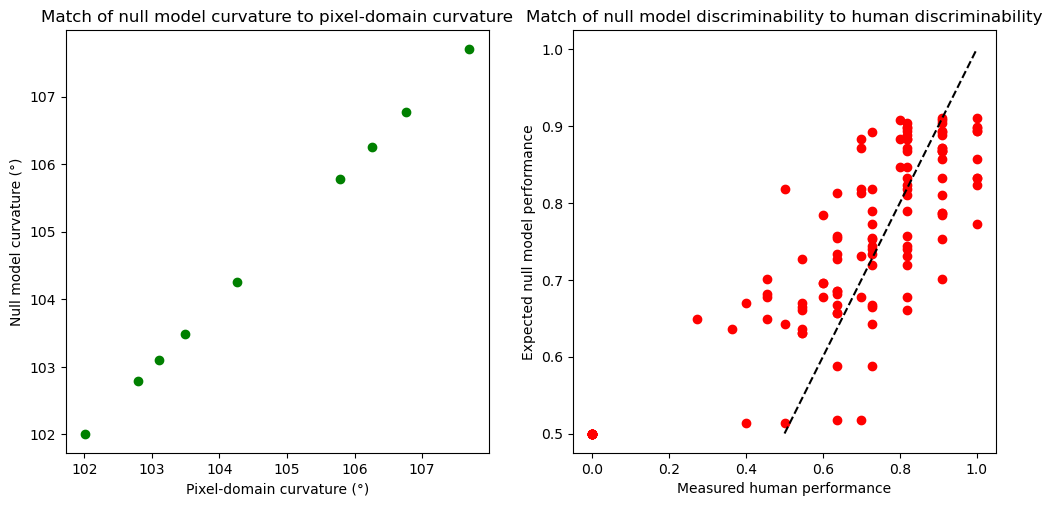

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Measured human performance')
axs[1].set_ylabel('Expected null model performance')
axs[1].set_box_aspect(1)

### Synthesize data from null model observer

In [6]:
# n_reps = int(np.max(n_total_obs))
n_reps = 10
prob_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.squeeze(), n_reps)

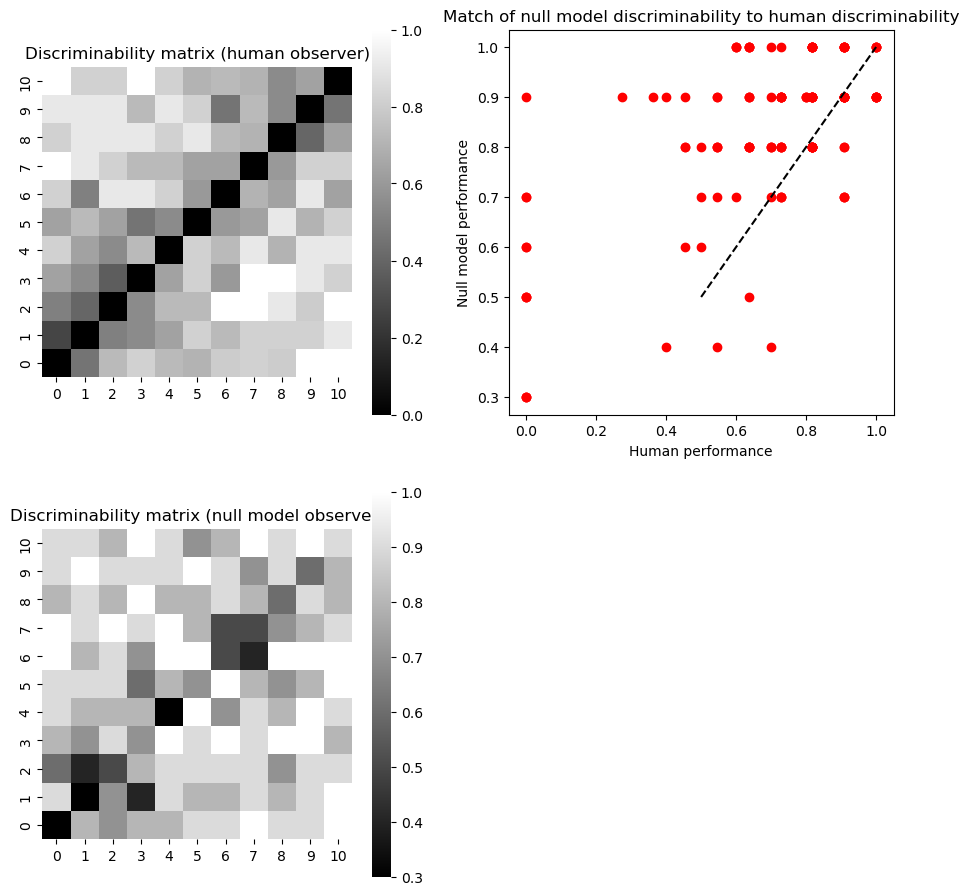

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

sns.heatmap(prob_corr_null_sim, ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[0, 1].plot(prob_corr_human.flatten(), prob_corr_null_sim.flatten(), 'ro')
axs[0, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 1].set_title('Match of null model discriminability to human discriminability')
axs[0, 1].set_xlabel('Human performance')
axs[0, 1].set_ylabel('Null model performance')
axs[0, 1].set_box_aspect(1)

axs[1, 1].set_axis_off()

### Run optimization on simulated data from null model

In [8]:
n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=80000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, _, _, _, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 520.1180463433266
Loss updated
Iteration 1 | Loss: 520.1180463433266
Current loss: 437.7769889384508
Loss updated
Iteration 2 | Loss: 437.7769889384508
Current loss: 434.07198064029217
Loss updated
Iteration 3 | Loss: 434.07198064029217
Current loss: 434.7114147543907
Iteration 4 | Loss: 434.7114147543907
Current loss: 440.9656335115433
Iteration 5 | Loss: 440.9656335115433
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 6 | Loss: 439.9174384921789
Current loss: 438.5789461955428
Iteration 7 | Loss: 438.5789461955428
Current loss: 434.2441526129842
Iteration 8 | Loss: 434.2441526129842
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 9 | Loss: 459.6166016161442
Current loss: 439.0382656827569
Iteration 10 | Loss: 439.0382656827569
Epoch: 0, Loss: 658.1372937362971
Epoch: 250, Loss: 629.6267997227399
Epoch: 500, Loss: 611.4814482933441
Epoch: 750, Loss: 598.5407970825281
Epoch: 1000, Loss: 585.0767632416421
Epoch: 1250, Loss: 

In [9]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

Estimated global curvature: 133.21823120117188 degrees
Average estimated local curvature: 133.21941356259202 degrees


### Run optimization on real data

In [10]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 1 | Loss: 649.3544379174709
Current loss: 638.5584446713328
Loss updated
Iteration 2 | Loss: 638.5584446713328
Current loss: 645.1685216501355
Iteration 3 | Loss: 645.1685216501355
Current loss: 659.0428224876523
Iteration 4 | Loss: 659.0428224876523
Current loss: 648.5553849712014
Iteration 5 | Loss: 648.5553849712014
Current loss: 654.3990533873439
Iteration 6 | Loss: 654.3990533873439
Current loss: 669.8639781177044
Iteration 7 | Loss: 669.8639781177044
Current loss: 643.7555441856384
Iteration 8 | Loss: 643.7555441856384
Current loss: 651.8715687319636
Iteration 9 | Loss: 651.8715687319636
Current loss: 639.0023939535022
Iteration 10 | Loss: 639.0023939535022
Epoch: 0, Loss: 1122.2978361184212
Epoch: 250, Loss: 1032.0312720283507
Epoch: 500, Loss: 962.2721578027652
Epoch: 750, Loss: 923.4510650400293
Epoch: 1000, Loss: 892.4915311977235
Epoch: 1250, Loss: 868.5964468119334
Epoch: 

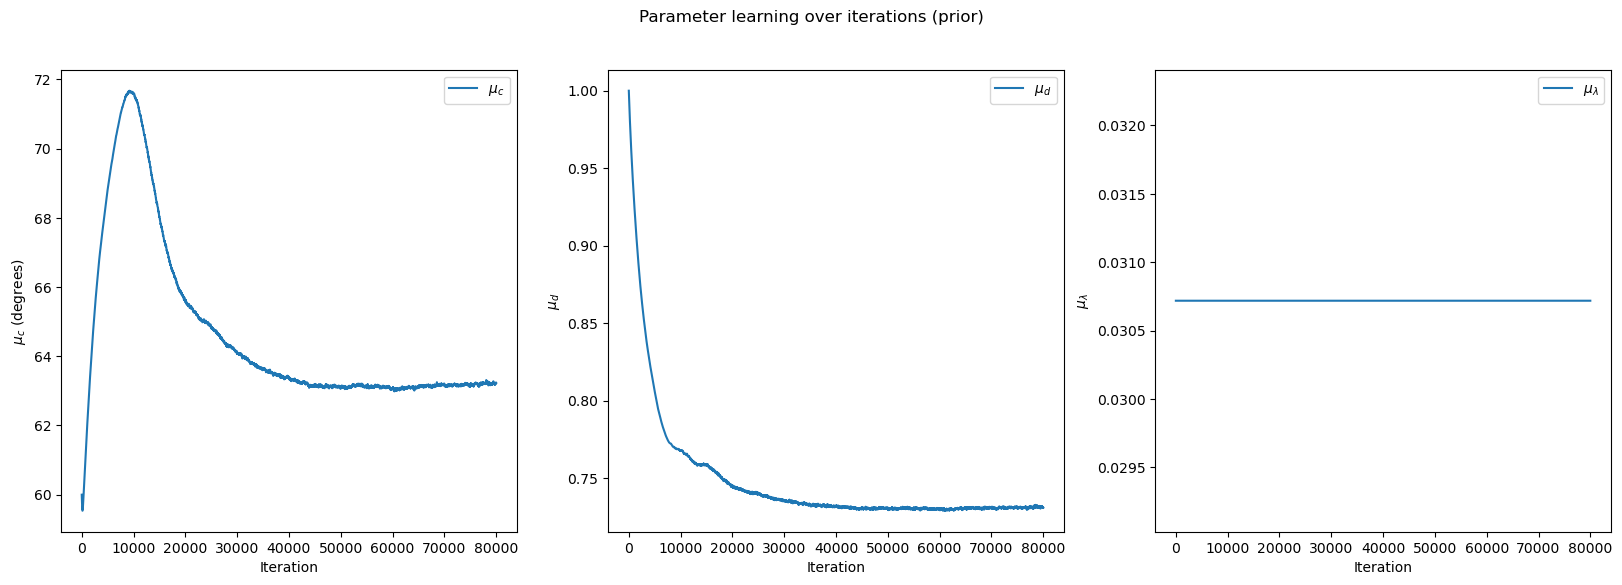

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/_c/tp58p8fd4t51w6w34tsknzpw0000gr/T/ipykernel_22309/2295650332.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post.T)


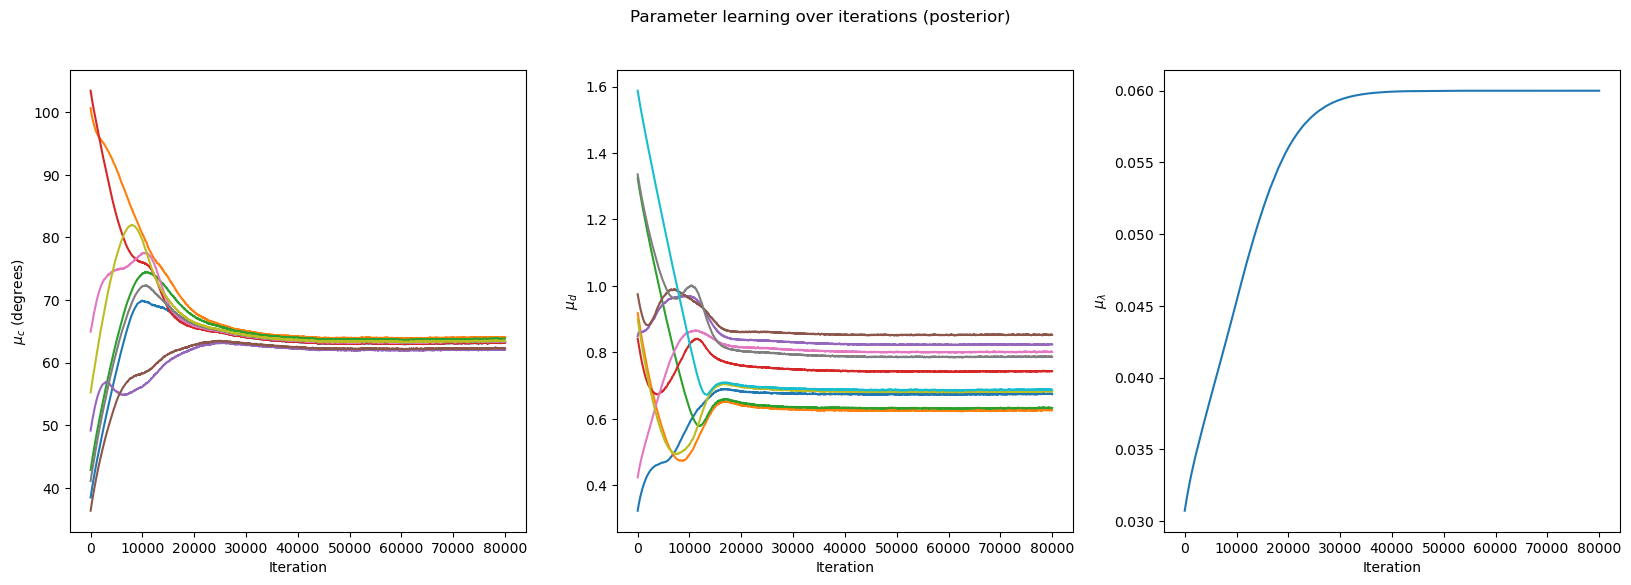

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [13]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 63.232177734375 degrees
Average estimated local curvature: 63.23045373227653 degrees


### Analyze results

In [14]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

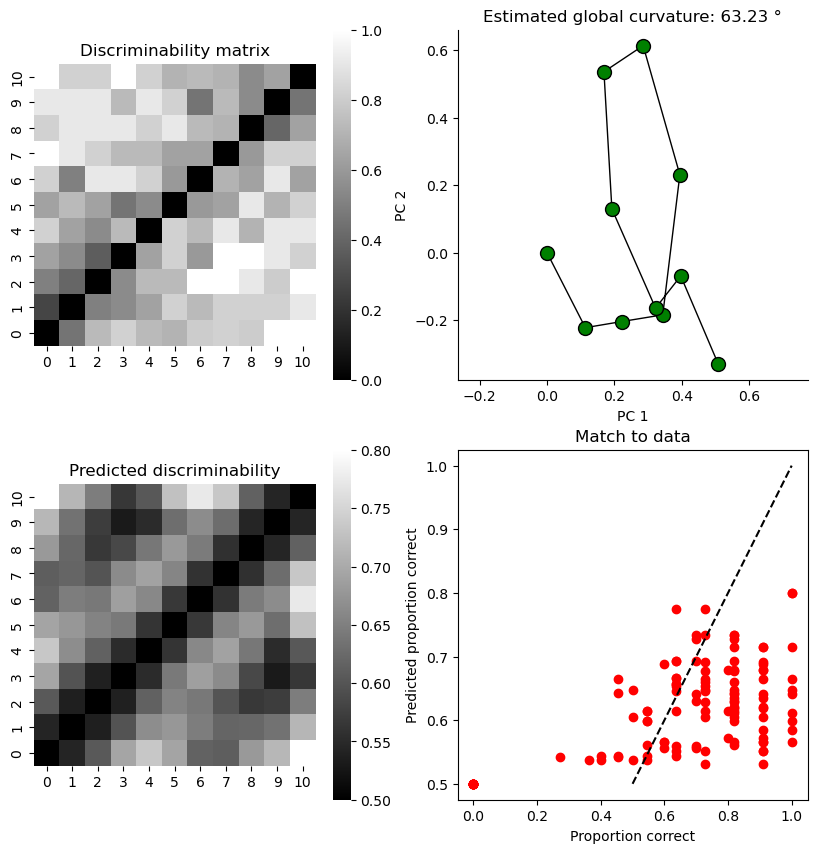

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()